# Урок 1. Data-driven-подход на примере задачи маршрутизации заявок в helpdesk

In [30]:
# Подключение исопльзуемых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [95]:
def show_model(model_col_0, model_col_1, title = None, ylabel = None, xlabel = None):
    plt.figure(figsize=(15,7))
    plt.plot(model_col_0, model_col_1, '.')
    plt.grid(alpha=.9)
    if title:
        plt.title(title)
    if ylabel:
        plt.ylabel(ylabel)
    if xlabel:
        plt.xlabel(xlabel)
    plt.show()

In [112]:
def show_std_mean_model(period, data, title):
    fig, ax = plt.subplots(1, 2, figsize=[20,5])
    
    ax[0].plot(data.resample(period).mean())
    ax[1].plot(data.resample(period).std(), c='g')
    
    ax[0].set_title(f"mean period {period}")
    ax[1].set_title(f"std period {period}")
    
    fig.suptitle(title, fontsize=14)
    
    return plt.show()

## 1. Выберите наборы данных, которые можно интерпретировать, как временные ряды:

   * зависимость цены на недвижимость в конкретном регионе от времени
   
        __Относится к временному ряду, т.к. цена зависит от времени__
   
   
   * скорость полета самолета при перелете из аэропорта А в аэропорт В
   
       __Не относится к временному ряду, т.к. скорость не зависит от времени__
   
   
   * количество отказов компьютера
   
       __Я бы отнес к временному ряду, т.к. через промежуток времени любая техника начинает отказывать из-за износа__
   
   
   * число обращений в поликлинику по району
   
       __Относится, если привязываться к временым метка пациента или времени года__
   
   
   * координаты автобуса при движении по маршруту
   
       __Не относится к временному ряду__
   
   
   * координаты фигуры нарушителя в файле видеофиксации охранной системы
       
       __Относится, т.к. координаты с каждой милиссекундой меняются__

## 2. Прочитайте DUQ_hourly.csv и проверьте качество и порядок разметки этой выборки с информацией о потреблении энергии в одном из районов Восточной Электросети США. Сделайте описание особенностей этой выборки.

In [3]:
df = pd.read_csv('DUQ_hourly.csv')

In [4]:
df.head(10)

,Datetime,DUQ_MW
0,2005-12-31 01:00:00,1458.0
1,2005-12-31 02:00:00,1377.0
2,2005-12-31 03:00:00,1351.0
3,2005-12-31 04:00:00,1336.0
4,2005-12-31 05:00:00,1356.0
5,2005-12-31 06:00:00,1372.0
6,2005-12-31 07:00:00,1402.0
7,2005-12-31 08:00:00,1425.0
8,2005-12-31 09:00:00,1502.0
9,2005-12-31 10:00:00,1556.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119068 entries, 0 to 119067
Data columns (total 2 columns):
Datetime    119068 non-null object
DUQ_MW      119068 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


### Cразу поправим тип данных в поле `DateTime`

In [9]:
col_0, col_1 = df.columns[0], df.columns[1]
df[col_0] = pd.to_datetime(df[col_0])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119068 entries, 0 to 119067
Data columns (total 2 columns):
Datetime    119068 non-null datetime64[ns]
DUQ_MW      119068 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 MB


In [11]:
df.describe()

,DUQ_MW
count,119068.000000
mean,1658.820296
std,301.740640
min,1014.000000
25%,1444.000000
50%,1630.000000
75%,1819.000000
max,3054.000000


### Проверим на пустые значения

In [18]:
df['DUQ_MW'].isnull().sum()

0

### Проверим на дубликаты

In [16]:
df[df.duplicated([col_0], keep=False)]

,Datetime,DUQ_MW
80286,2014-11-02 02:00:00,1272.0
80287,2014-11-02 02:00:00,1240.0
89070,2015-11-01 02:00:00,1113.0
89071,2015-11-01 02:00:00,1138.0
97710,2016-11-06 02:00:00,1121.0
97711,2016-11-06 02:00:00,1107.0
106518,2017-11-05 02:00:00,1131.0
106519,2017-11-05 02:00:00,1105.0


In [17]:
df[col_0].value_counts().head(5)

2017-11-05 02:00:00    2
2014-11-02 02:00:00    2
2015-11-01 02:00:00    2
2016-11-06 02:00:00    2
2007-07-15 10:00:00    1
Name: Datetime, dtype: int64

__Имеются 4 пары дубликатов. Удалим дубликаты, сохранив первые значения из пар:__

In [23]:
df = df.drop_duplicates(col_0, keep='first')

In [24]:
### Посмотрим что показывает график по данным

In [91]:
show_model(df[col_0], df[col_1])

KeyError: 'Datetime'

Заметны сезонные колебания, так же просматриваются колебания с большим периодом, скорей всего было большое потребление в связи с праздником или еще каким-то трендом.

### Посмотрим на минимумы и макисмумы

In [28]:
df.nlargest(10, "DUQ_MW")

,Datetime,DUQ_MW
65781,2012-06-29 14:00:00,3054.0
12372,2006-08-03 16:00:00,3053.0
12373,2006-08-03 17:00:00,3046.0
12397,2006-08-02 17:00:00,3035.0
65353,2012-07-17 18:00:00,3029.0
12371,2006-08-03 15:00:00,3027.0
12395,2006-08-02 15:00:00,3027.0
65782,2012-06-29 15:00:00,3024.0
12396,2006-08-02 16:00:00,3023.0
65783,2012-06-29 16:00:00,3019.0


In [27]:
df.nsmallest(10, "DUQ_MW")

,Datetime,DUQ_MW
93587,2015-04-27 06:00:00,1014.0
93779,2015-04-19 06:00:00,1020.0
93777,2015-04-19 04:00:00,1024.0
93778,2015-04-19 05:00:00,1025.0
102082,2016-05-08 05:00:00,1028.0
102586,2016-04-17 05:00:00,1036.0
93776,2015-04-19 03:00:00,1039.0
102585,2016-04-17 04:00:00,1039.0
102081,2016-05-08 04:00:00,1043.0
102584,2016-04-17 03:00:00,1047.0


__Здесь видим, что наибольшее потребление было зафиксировано наибольшее количество раз в августе 2006, так же наименьшее потребление несколько раз зафиксировано в апреле 2015 года, посмотрим эти периоды поподробнее:__

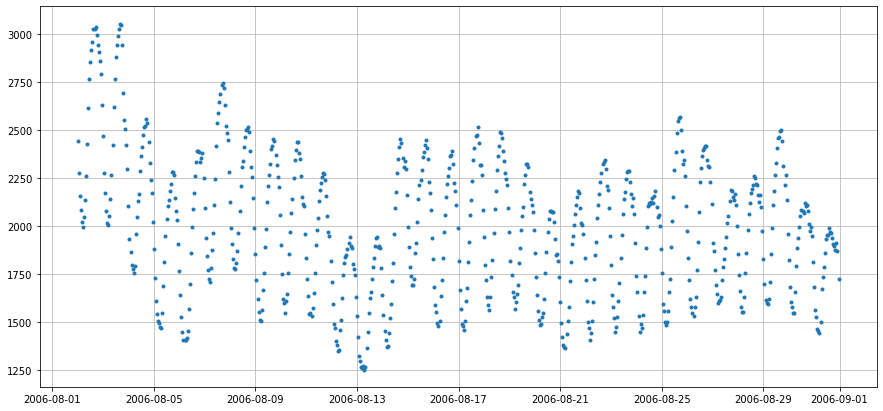

In [61]:
df['date'] = df['Datetime']
df_2006 = df.loc[np.logical_and(np.logical_and(df['date'].dt.year == 2006 , df['date'].dt.month == 8), df['date'].dt.day > 1)]

show_model(df_2006[col_0], df_2006[col_1])

__Видим, что в начале месяца был большой скачек электронапряжения, есть предположение, что люди начали возвращаться с отпусков и включать электроприборы, для хощяйственных нужд, т.к. 01.08.2006 никаких значимых происшествий не было.__

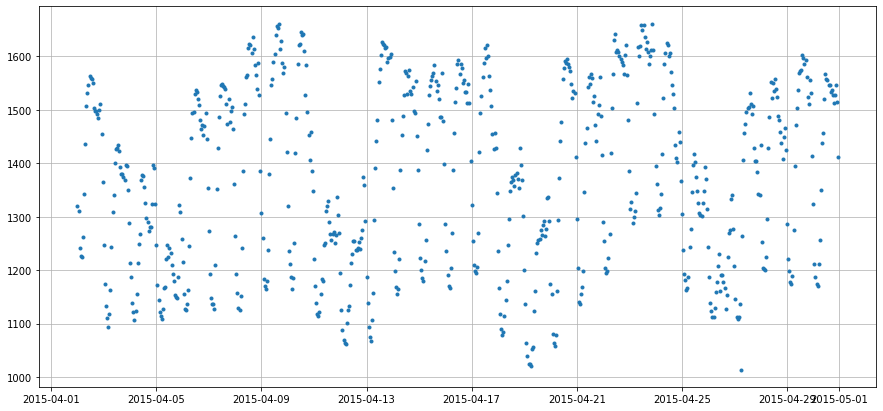

In [62]:
df['date'] = df['Datetime']
df_2015 = df.loc[np.logical_and(np.logical_and(df['date'].dt.year == 2015 , df['date'].dt.month == 4), df['date'].dt.day > 1)]

show_model(df_2015[col_0], df_2015[col_1])

__По графику, визуально, не бросается никакие аномалии, хотя были зафиксированы минимальные значения__

В исследуемом датасете представлены данные по потреблению электроэнергии за 2005-2018 годы, данные имеют циклический характер, потребление изменяется в зависимости от сезона. Выбросов в датасете не обнаружено, максимум выбивается из общей картины с периодичностью, но ничего анамального не быол замеченго, в то вроемя как минимум потребления не выбивается из общей картины. В датасете были задвоенныя в количестве - 4 шт, что связано с переходом на зимнее-летнее время.

### 3. Прочитайте базу Brent и сделайте ее перерасчет (ресемплинг) в представление по неделям , по месяцам.

In [74]:
df = pd.read_excel('нефть-brent 2010-2019.xlsx', index_col=[0], parse_dates=[0])

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2019-09-01 to 2010-09-01
Data columns (total 1 columns):
Значение    2667 non-null float64
dtypes: float64(1)
memory usage: 41.7 KB


In [83]:
df.head(10)

,Значение
Дата,
2019-09-01,58.84
2019-08-30,59.19
2019-08-29,60.37
2019-08-28,59.84
2019-08-27,59.59
2019-08-26,58.26
2019-08-25,57.81
2019-08-23,58.94
2019-08-22,60.05


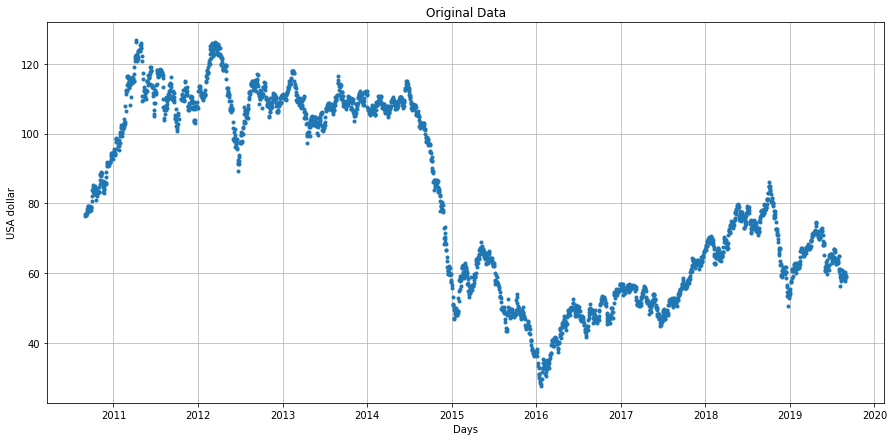

In [98]:
show_model(df.index, df.values, title = 'Original Data', ylabel = 'USA dollar', xlabel = 'Days')

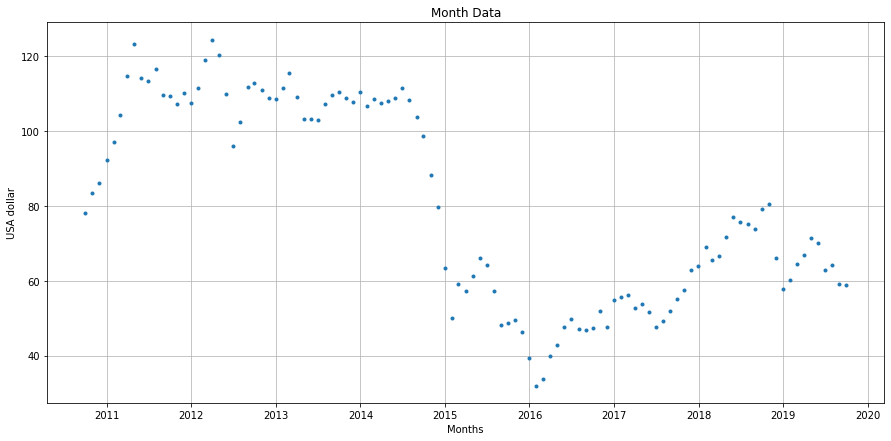

In [99]:
df_month = df.resample("M").mean()
show_model(df_month.index, df_month.values, title = 'Month Data', ylabel = 'USA dollar', xlabel = 'Months')

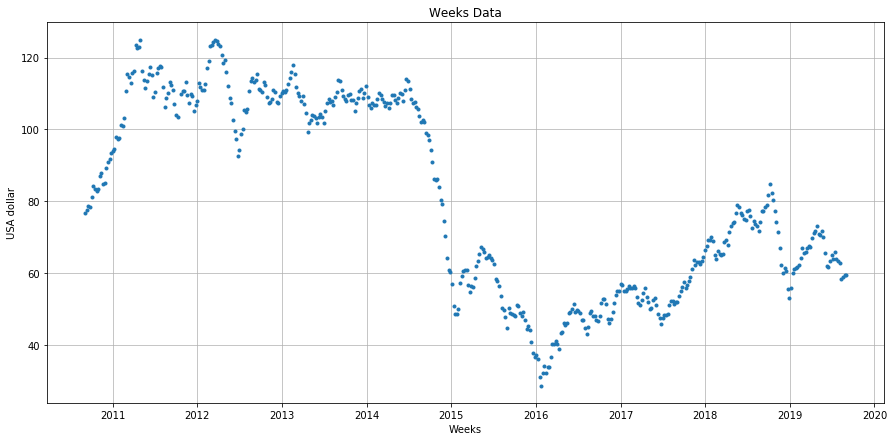

In [101]:
df_week = df.resample("W").mean()
show_model(df_week.index, df_week.values, title = 'Weeks Data', ylabel = 'USA dollar', xlabel = 'Weeks')

### 4. Постройте график изменения среднего по выборке и среднего отклонения по выборке на недельных и месячных группах для Brent.

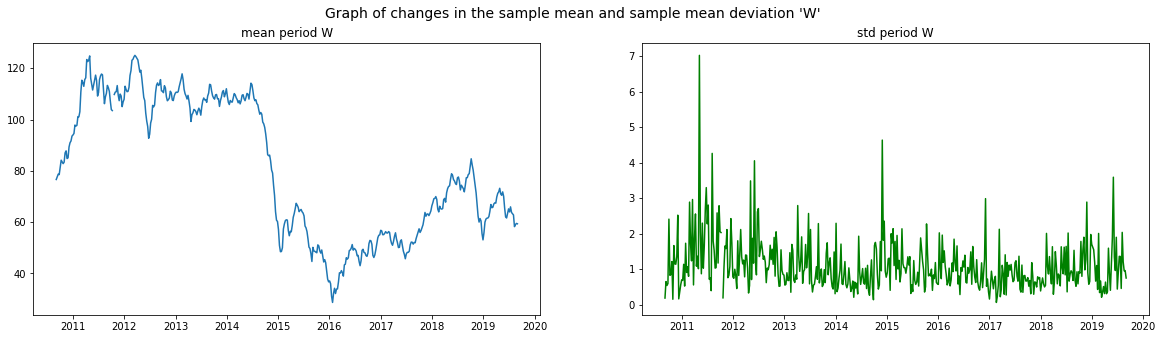

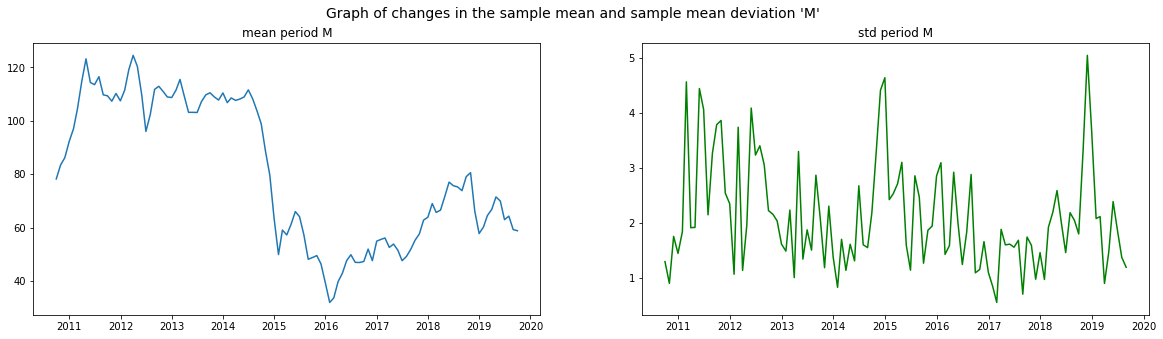

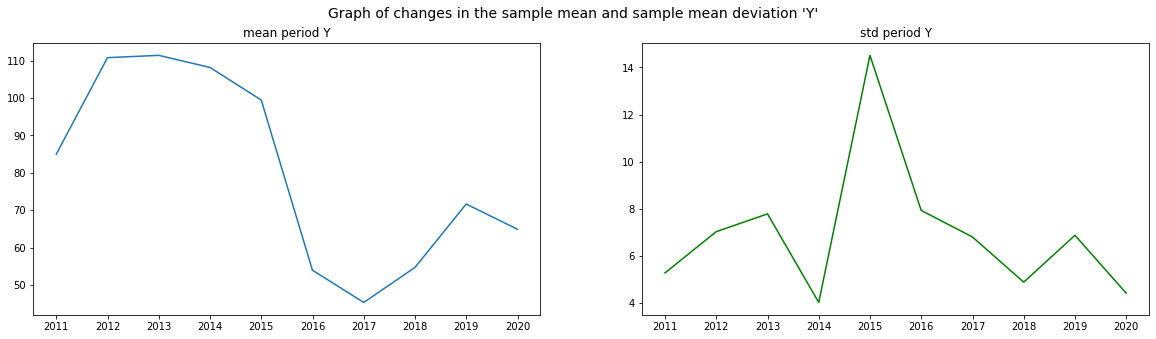

In [114]:
for period in ['W', 'M', 'Y']:
    show_std_mean_model(period, df, f"Graph of changes in the sample mean and sample mean deviation '{period}'")

### 5. Сделайте вывод о том, как изменилось поведение цены на недельных и месячных графиках по сравнению с годовым.

Из графиков можно подметить, что видны наиболее резкие изменения цены на нефть. В представлении по неделям график указывает на начало 2011 года, график по месяцам показывает на самое резкое изменение в конце 2018 года, в то время как в графике по годам видно, что боль всего изменялись цены в 2014 году.